<a href="https://colab.research.google.com/github/ymuto0302/base2_2020/blob/master/Mesa_introductory_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mesa のチュートリアルを追いかける
https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html

Mesa とは，エージェントベースのモデリング・フレームワークである。
・・・って，これじゃ意味が伝わらない。「**マルチエージェントシミュレーションを実現するための仕組み／関数の集まり**」と捉えればよい。

本チュートリアルで扱うテーマは "Boltzmann Wealth Model" である（これは econophysics＝経済物理学の世界を MAS で表現したものである）。

極めて単純なモデルであり，

1. 複数のエージェントが存在する
1. 全てのエージェントは１単位のお金を有する状態から始める
1. モデルの各ステップにおいて，あるエージェントは他のエージェントへ１単位のお金を与える

というものである。

チュートリアルの流れは，
- 最初に，お金を交換するエージェントをモデル化する。
- 次に，エージェントが行動する空間(space)を加える。
- その後，data collector と batch runner を用いる。
- 最後に iterative visualization を付け加える。

という形である。

## (準備) Mesa のインストール

In [ ]:
!pip install mesa

# ここから本論

### Setting up the model
MAS (multi-agent simulation)を Mesa 上で実現するためには，エージェント(Agent)とモデル(Model)をクラスとして実装する必要がある。

- エージェント・クラスには，個々のエージェントを区別するための unique_id が必要となる（区別できればよいから，固有名詞でも，連番の数値でもよい）。
- シミュレーション全体を統括するモデルでは，エージェントの生成／スケジューラーの設定／空間の設定／データ・コレクタの設定などが含まれる。

以下のコードでは，num_agents の数だけ MoneyAgent オブジェクトを生成している。

In [ ]:
from mesa import Agent, Model

class MoneyAgent(Agent):
    # An agent with fixes initial wealth
    # unique_id : 個々のエージェントを区別するための ID
    def __init__(self, unique_id, model):
        super.__init__(unique_id, model)
        self.wealth = 1 # エージェントの有する富
        
class MoneyModel(Model):
    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

### Adding the scheduler
スケジューラ (scheduler)とは，活性化させるエージェントの順番で制御する仕組みである。

以下では，ランダムな順番で，全てのエージェントを活性化させる RandomActivation を用いる。

プログラムの流れは以下のとおり：
1. モデル内でスケジューラを定義する
1. そのスケジューラに生成されたエージェントを追加する。これによってエージェントにスケジュールが付与される。
1. モデル MoneyModel の step() メソッドが呼ばれると，スケジューラの step メソッド (schedule.step()) が実行される。すると，エージェントの順番をシャッフルした上で，個々のエージェントの step メソッドが実行される。

実行結果を見ると，エージェントの unique_id がランダムに並び，個々のエージェントの情報が表示されているのが分かるだろう。

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation

class MoneyAgent(Agent):
    # An agent with fixes initial wealth
    # unique_id : 個々のエージェントを区別するための ID（名前みたいなもの）
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1 # エージェントの有する富

    def step(self):
        # For demonstration purposes we will print the agent's unique_id
        print("Hi, I am agent {}. I have {} money.".format(self.unique_id, self.wealth))
              
class MoneyModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self) # スケジューラ
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
    def step(self):
        # Advance the model by one step
        self.schedule.step()
        
empty_model = MoneyModel(10)
empty_model.step()

Hi, I am agent 5. I have 1 money.
Hi, I am agent 4. I have 1 money.
Hi, I am agent 8. I have 1 money.
Hi, I am agent 3. I have 1 money.
Hi, I am agent 1. I have 1 money.
Hi, I am agent 0. I have 1 money.
Hi, I am agent 9. I have 1 money.
Hi, I am agent 7. I have 1 money.
Hi, I am agent 6. I have 1 money.
Hi, I am agent 2. I have 1 money.


### Agent Step
エージェントの step() メソッドを拡張し，財産(wealth)をランダムに選択された他のエージェントに渡す仕組みを実装した。

ここで model.random は乱数生成器である。また，model.choice() はランダムにひとつの値を選ぶ関数である。

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation

class MoneyAgent(Agent):
    # An agent with fixes initial eralth
    # unique_id : 個々のエージェントを区別するための ID（名前みたいなもの）
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1 # エージェントの有する富

    def step(self):
        # 財産がゼロになったら何もしない
        if self.wealth == 0:
            return
        
        # エージェント群からランダムにひとつのエージェントを選び
        # 財産を１単位，渡す（自分の財産は１単位，減少）
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1
        
class MoneyModel(Model):
    # A model with some number of agents
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self) # スケジューラ
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
    def step(self):
        # Advance the model by one step
        self.schedule.step()
        
model = MoneyModel(10)
for i in range(10): # 10 steps
    model.step()

### Distribution of the agent's wealth
上記のコードを実行した結果，10ステップを実行し，各ステップにおいてエージェント間で財産がやりとりされた。

以下では，10ステップ経過後の「個々のエージェントが有する財産の量」をヒストグラムで眺めてみる。結果として，10体のエージェントのうち，6体が財産ゼロとなっていることが分かる。

(array([3., 0., 0., 5., 0., 0., 1., 0., 0., 1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

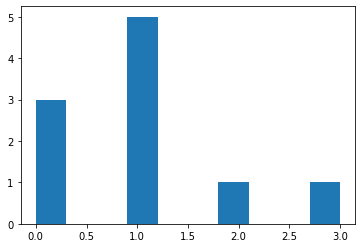

In [ ]:
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

### Create multiple model runs
MAS では乱数を利用するため，実行する度に異なる結果が得られる。この問題を解消するため，多くの試行が必要となる。

以下のコードは，10ステップのシミュレーションを 100回試行するものである。
ヒストグラムから分かるように，財産ゼロが最多数，次に財産が１単位・２単位・・。という形で頻度が減少する。

**(注) この実装は，今後，出てこない**

(array([433., 291., 168.,  71.,  26.,  11.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

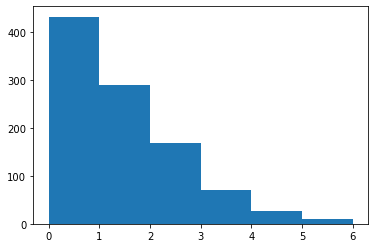

In [ ]:
all_wealth = []

# this runs the model 100 times, each model excuting 1- steps.
for j in range(100): # 100 instantiations of the model
    # Run the model
    model = MoneyModel(10) # 10 agents
    for i in range(10): # 10 steps
        model.step()
        
    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)
        
plt.hist(all_wealth, bins=range(max(all_wealth)+1))

(メモ) 何故，大部分のエージェントはすっからかんになり，僅かなエージェントのみ富が増えているのだろうか。

### Adding space
エージェントが行動する空間はグリッド(grid)により表現される。

Mesa は SingleGrid と MultiGrid の２タイプのグリッドを有する。
- SingleGrid : ひとつのセルに単一のエージェントのみが存在できる
- MultiGrid  : ひとつのセルに複数のエージェントが同時に存在できる

以下は MultiGrid を利用したコードである。
1. モデル MoneyModel 内で「幅，高さ，トーラス状であること」を指定し，MultiGrid を定義する。
1. その後，グリッド内の座標をランダムに選び，grid.place_agent() を用いてエージェントを配置する。


In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid

class MoneyAgent(Agent):
    # An agent with fixes initial eralth
    # unique_id : 個々のエージェントを区別するための ID（名前みたいなもの）
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1 # エージェントの有する富

    def step(self):
        # 財産がゼロになったら何もしない
        if self.wealth == 0:
            return
        
        # エージェント群からランダムにひとつのエージェントを選び
        # 財産を１単位，渡す（自分の財産は１単位，減少）
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1
        
class MoneyModel(Model):
    # A model with some number of agents
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, torus=True)
        self.schedule = RandomActivation(self) # スケジューラ
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            
            # 名称どおり，エージェント a を (x, y) に設置
            # (メモ) place_agent メソッドにより，エージェントに位置 (x,y) が紐づく
            self.grid.place_agent(a, (x, y))
            
    def step(self):
        self.schedule.step()
        
model = MoneyModel(50, 10, 10)
for i in range(10): # 10 steps
    model.step()

### 近傍の導入
近傍の表現として，ノイマン近傍 (Nuemann neighborhood) とムーア近傍 (Moore neighborhood) が知られている。

近傍の設定は model.grid.get_neighborhood() を用いて行う（**自分で明示的に座標を指定しない**）。本関数の引数は以下のとおり：
- self.pos : エージェントの現在位置
- moore = True : ムーア近傍を利用する指定
- include_center = False : 近傍として中心セルを含まない指定

以下のコードでは，得られた近傍情報を possible_steps（移動可能な場所）として取得し，そこからランダムにセルを選択（これが変数 new_position)したのち，model.grid.move_agent(self, new_position) を用いてエージェントを移動させている。

さらに，移動後，（自身の財産があるならば）自身と同じセルに存在する他エージェントへ財産を渡す実装となっている。
- `cellmates = self.model.grid.get_cell_list_contents([self.pos])` : model.grid.get_cell_list_contents() を用いて，現在位置 self.pos に存在するエージェントの一覧を得る
- `other = self.random.choice(cellmates) ` : cellmates からランダムに１体のエージェントを選び，財産の贈与先とする。
            

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid

class MoneyAgent(Agent):
    # An agent with fixes initial eralth
    # unique_id : 個々のエージェントを区別するための ID（名前みたいなもの）
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1 # エージェントの有する富

    def step(self):
        # 動作確認用のコード
        if self.unique_id == 3:
            print("id:{}, pos:{}, money:{}".format(self.unique_id, self.pos, self.wealth))

        # 移動
        self.move()
        # 財産があれば，近傍の他エージェントへ与える
        if self.wealth > 0:
            self.give_money()
            
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = True, # Moore 近傍
            include_center = False)
        
        # 自分自身を new_position へ動かす
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        # 自分の位置 (self.pos) と同じセルにいる他のエージェントを探す
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates) # (メモ) self == other の場合もあり得る
            other.wealth += 1
            self.wealth -= 1
            
class MoneyModel(Model):
    # A model with some number of agents
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self) # スケジューラ
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            
            # 名称どおり，エージェント a を (x, y) に設置
            # (メモ) place_agent メソッドにより，エージェントに位置 (x,y) が紐づく
            self.grid.place_agent(a, (x, y))
            
    def step(self):
        # Advance the model by one step
        self.schedule.step()
        
model = MoneyModel(50, 10, 10)
for i in range(20): # 20 steps
    print("step {}: ".format(i), end="") # 動作確認用のコード
    model.step()

step 0: id:3, pos:(9, 3), money:1
step 1: id:3, pos:(0, 2), money:1
step 2: id:3, pos:(9, 2), money:2
step 3: id:3, pos:(0, 3), money:3
step 4: id:3, pos:(9, 4), money:4
step 5: id:3, pos:(8, 3), money:4
step 6: id:3, pos:(8, 2), money:4
step 7: id:3, pos:(8, 1), money:4
step 8: id:3, pos:(8, 2), money:4
step 9: id:3, pos:(7, 2), money:4
step 10: id:3, pos:(6, 3), money:5
step 11: id:3, pos:(5, 3), money:5
step 12: id:3, pos:(4, 2), money:6
step 13: id:3, pos:(5, 2), money:6
step 14: id:3, pos:(6, 3), money:6
step 15: id:3, pos:(6, 4), money:6
step 16: id:3, pos:(6, 3), money:6
step 17: id:3, pos:(5, 4), money:6
step 18: id:3, pos:(4, 5), money:5
step 19: id:3, pos:(3, 4), money:5


### おまけ
10×10 のグリッドの各セルに何体のエージェントがいるかを可視化した結果である。

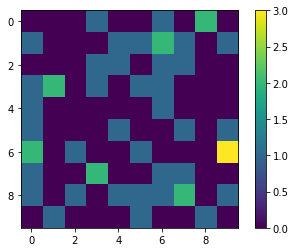

In [ ]:
# 各々のセルにいるエージェント数を数える
import numpy as np
import matplotlib.pyplot as plt

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter(): # 座標を全て舐めていく
    cell_content, x, y = cell
    agent_count = len(cell_content) # 座標 (x,y) に存在するエージェント数
    agent_counts[x][y] = agent_count
    
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

### Collecting Data
シミュレーションが進行（＝ステップを重ねる）際の途中のデータを収集したい場合がある。
そのような要望に応えるのが DataCollector である。

DataCollector はモデル内で定義され，「モデルが報告するデータ」と「個々のエージェントが報告するデータ」を指定可能である。以下のコードでは，モデルが報告するデータとしてジニ係数，個々のエージェントが報告するデータとして財産の量を指定している。

```
self.datacollector = DataCollector(
    model_reporters = {"Gini": compute_gini},
    agent_reporters = {"Wealth": "wealth"}
)
```        

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N-i) for i, xi in enumerate(x)) / (N * sum(x))
    return (1 + (1/N) - 2 * B)

class MoneyAgent(Agent):
    # An agent with fixes initial wealth
    # unique_id : 個々のエージェントを区別するための ID（名前みたいなもの）
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1 # エージェントの有する富

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
            
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = True, # Moore 近傍
            include_center = False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position) # 自分自身を new_position へ動かす
        
    def give_money(self):
        # 自分の位置 (self.pos) と同じセルにいる他のエージェントを探す
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates) # (メモ) self == other の場合もあり得る
            other.wealth += 1
            self.wealth -= 1
            
class MoneyModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self) # スケジューラ
        self.running = True
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            # エージェント a を (x, y) に設置
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        # DataCollector の定義
        self.datacollector = DataCollector(
            model_reporters = {"Gini": compute_gini},
            agent_reporters = {"Wealth": "wealth"}
        )
            
    def step(self):
        # Advance the model by one step
        # 各ステップにおいてデータを集める。
        # model-level では GINI 係数；agent-level では wealth を集積
        self.datacollector.collect(self)
        
        self.schedule.step()

model = MoneyModel(50, 10, 10)
for i in range(100): # 100 steps
    model.step()

#### モデルが報告したデータの利用
`model.datacollector.get_model_vars_dataframe()` を用いて「モデルが報告したデータ」を取得できる。
ここで得られるデータ形式は Pandas データフレームである。

データフレームの値をプロットした結果，ジニ係数はステップの進行に合わせて増加している，すなわち不平等さが増していることが分かる。

<AxesSubplot:>

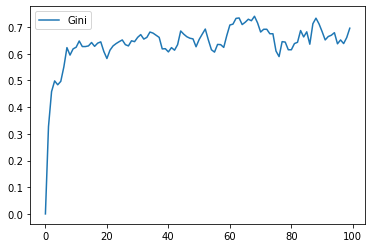

In [ ]:
# GINI係数の列を取り出す
gini = model.datacollector.get_model_vars_dataframe() # Pandas dataframe の形式
gini.plot()

#### エージェントが報告したデータの利用
`model.datacollector.get_agent_vars_dataframe()` を用いて「エージェントが報告したデータ」を取得できる。
ここで得られるデータ形式は Pandas データフレームである。

下記の実行例から明らかなように，ステップごとに個々のエージェントの有する財産(wealth)の量が格納されている。

In [ ]:
# agent-wealth dataを取り出す
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
99   45            0
     46            1
     47            0
     48            4
     49            0

[5000 rows x 1 columns]

<AxesSubplot:>

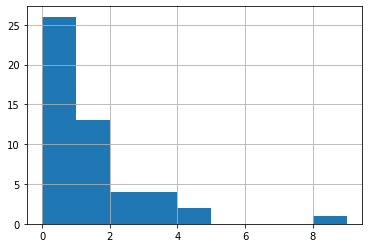

In [ ]:
# 最終段階での agent wealth のヒストグラムを生成
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

<AxesSubplot:xlabel='Step'>

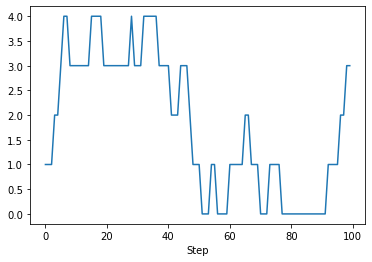

In [ ]:
# 特定のエージェントの wealth の変化を見る
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

## シミュレーションの可視化
Anaconda では動作するが，Google Colaboratory では動作しない。

In [ ]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

'''
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal
'''

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step

{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":"get_step","step":300}
{"type":"get_step","step":301}
{"type":

{"type":"get_step","step":535}
{"type":"get_step","step":536}
{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":"get_step","step":566}
{"type":